In [110]:
import numpy as np 
import matplotlib.pyplot as plt 

# Image loading packages
from PIL import Image
from io import BytesIO
import requests

#### Load online image to a numpy array

image_array.shape:  (250, 250)


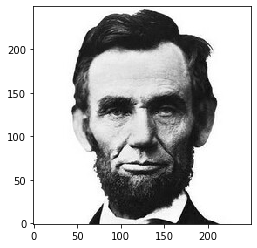

In [111]:
# URL of the image
image_url = 'https://raw.githubusercontent.com/MurpheyLab/ME455_public/main/figs/lincoln.jpg'

# Fetch the image data from the URL
response = requests.get(image_url)

# Create a BytesIO object from the response data
image_data = BytesIO(response.content)

# Open the image using PIL
image = Image.open(image_data)

# Convert the image to a NumPy array
image_array = np.array(image)
image_array = np.flip(image_array, axis=0)

print('image_array.shape: ', image_array.shape)

plt.imshow(image_array, origin='lower', cmap='gray') # note that for "imshow" the origin of the coordinate is at top left instead of bottom left
plt.show()
plt.close()

#### Converting image to a continuous density function

We assume this image represents a continuous density function p(x) over a 1 meter-by-1 meter space. 
In other words, we will convert the coordinate of each pixel of this 250-by-250 image to a 1m-by-1m space.

For example, the bottom right pixel has the coordinate (249,249) in the image coordinate, we will transform it to be (1.0, 1.0) in the new space. 

**Note: we want higher density at regions that are darker, so we need to evaluate the density as "255 - pixel_density".**

In [112]:
xgrids = np.linspace(0.0, 1.0, image_array.shape[0])  # the x coordinates of image pixels in the new space
dx = xgrids[1] - xgrids[0]
ygrids = np.linspace(0.0, 1.0, image_array.shape[1])  # the y coordinates of image pixels in the new space
dy = ygrids[1] - ygrids[0]

# we now invert dark and light pixel density and normalize the density values so it is a valid probability distribution
density_array = 255.0 - image_array  # we want higher density at darker regions
density_array /= np.sum(density_array) * dx * dy  # so the integral is 1

def image_density(s):
    """ Continuous density function based on the image
    Inputs:
        s - a numpy array containing the (x,y) coordinate within the 1m-by-1m space
    Return:
        val - the density value at s
    """
    s_x, s_y = s

    # Find the pixel closest to s in the 1-by-1 space
    # Note that in image the first pixel coordinate correspond to the y-axis in the 1-by-1 space
    pixel_idx_y = np.argmin(np.abs(xgrids - s_x))
    pixel_idx_x = np.argmin(np.abs(ygrids - s_y))

    # the density at s is the same as the closest pixel density
    val = density_array[pixel_idx_x, pixel_idx_y]

    return val

We can verify the density function through importance sampling.

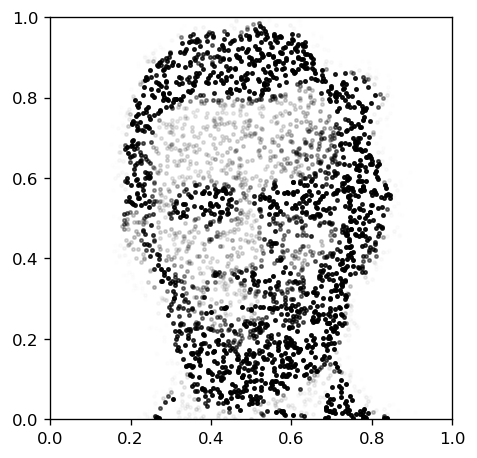

In [113]:
num_samples = 5000
samples = np.random.uniform(low=0.0, high=1.0, size=(num_samples,2))
sample_weights = np.zeros(num_samples)

for i in range(num_samples):
    sample_weights[i] = image_density(samples[i])

# for visualization purpose, we adjust the weights such that the maximum weight is 1.0 
# (matplotlib only accepts values between 0.0 to 1.0 as the opacity value)
# (this is not the same as normalization in importance sampling or rejection sampling)
sample_weights /= np.max(sample_weights)

# now we visualize the weighted samples
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=120, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

for sample, weight in zip(samples, sample_weights):
    ax.plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k', alpha=weight)

plt.show()
plt.close()